In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)

In [2]:
df_demographics = pd.read_csv('dunnhumby-the-complete-journey/hh_demographic.csv')
df_demographics.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [3]:
df_transactions = pd.read_csv('dunnhumby-the-complete-journey/transaction_data.csv')
print('number of all transactions: ' +str(df_transactions.shape[0]))
df_transactions.head()

number of all transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
transactions_with_demographic = df_transactions.merge(df_demographics, on='household_key', how='right')
print('number of transactions of people we have demographic info about: ' +str(transactions_with_demographic.shape[0]))


number of transactions of people we have demographic info about: 1427303


In [5]:
df_product = pd.read_csv('dunnhumby-the-complete-journey/product.csv')
gas_product_ids = df_product[df_product['SUB_COMMODITY_DESC'] == "GASOLINE-REG UNLEADED"]['PRODUCT_ID'].tolist()

fuel_transactions = transactions_with_demographic[transactions_with_demographic['PRODUCT_ID'].isin(gas_product_ids)]
print('number of transactions (only fuel) of people we have demographic info about: ' +str(fuel_transactions.shape[0]))

fuel_basket_ids = fuel_transactions['BASKET_ID'].unique()
print('number of baskets that have fuel in it: ' +str(fuel_transactions.shape[0]))


number of transactions (only fuel) of people we have demographic info about: 14772
number of baskets that have fuel in it: 14772


In [6]:
grocery_transactions = transactions_with_demographic[~(transactions_with_demographic['BASKET_ID'].isin(fuel_basket_ids))]
print('number of transactions (excluding fuel) of people we have demographic info about: ' +str(grocery_transactions.shape[0]))


number of transactions (excluding fuel) of people we have demographic info about: 1411931


In [7]:
big_big_transaction_table = grocery_transactions.merge(df_product, on='PRODUCT_ID', how='inner')
big_big_transaction_table.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
1,304,27950201718,81,842930,1,1.67,333,-0.52,1242,12,0.0,0.0,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
2,575,34186568032,485,842930,1,1.67,433,-0.62,2123,70,0.0,0.0,35-44,U,50-74K,Unknown,Single Female,1,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
3,77,28023861855,87,842930,3,5.00,346,-1.57,1844,13,0.0,0.0,35-44,A,100-124K,Homeowner,2 Adults Kids,5+,3+,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ
4,2317,27924836708,79,842930,2,3.33,372,-1.05,1326,12,0.0,0.0,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ


In [8]:
# Summing individual transactions to have total basket value
transactions_aggregated = big_big_transaction_table.groupby(["household_key","BASKET_ID",'STORE_ID', "DAY", "WEEK_NO","TRANS_TIME"])["SALES_VALUE"].sum().reset_index().sort_values(by='SALES_VALUE', ascending=False)
print('number of baskets: ' + str(transactions_aggregated.shape[0]))

# add demographic data
transactions_aggregated = transactions_aggregated.merge(df_demographics, on='household_key')

transactions_aggregated.sort_values(['household_key','DAY']).head(10)


number of baskets: 125574


,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
78127,1,27601281299,436,51,8,1456,78.66,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78150,1,27774192959,436,67,10,2002,41.10,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78160,1,28024266849,436,88,13,1604,26.90,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78138,1,28106322445,436,94,14,1937,63.43,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78145,1,28235481967,436,101,15,1603,53.45,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78162,1,28282581446,436,108,16,1513,26.76,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78166,1,28318295376,31401,111,17,1157,23.55,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78108,1,28601601153,436,128,19,1444,110.34,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78118,1,28744672720,436,137,20,2003,87.44,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
78131,1,28853646373,436,146,22,1538,73.32,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown


In [9]:
non_numerical_columns = ['household_key','BASKET_ID','STORE_ID','AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']
categorical_columns = ['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC']

other_columns = list(filter(lambda x: x not in non_numerical_columns, transactions_aggregated.columns.tolist()))
                       
other_columns

['DAY', 'WEEK_NO', 'TRANS_TIME', 'SALES_VALUE']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1059f8ad0>,
      dtype=object)

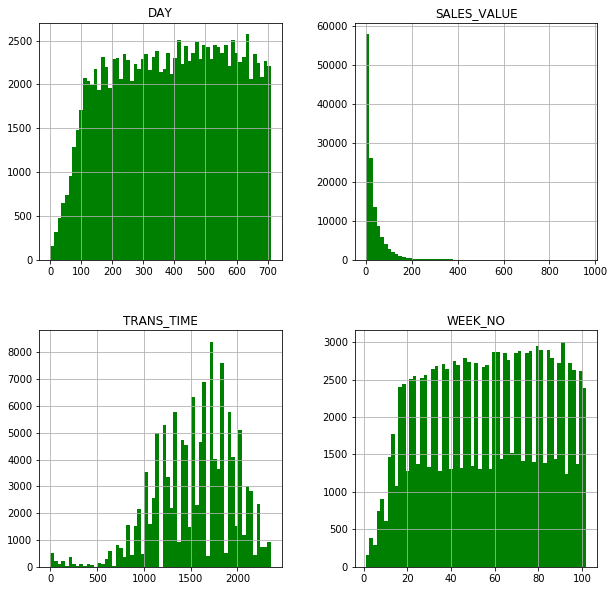

In [10]:
transactions_aggregated[other_columns].hist(bins=61, figsize=(10, 10), color='g')


In [11]:
for i,feat in enumerate(categorical_columns):
    print(transactions_aggregated[feat].value_counts())


45-54    46158
35-44    32252
25-34    20039
65+      10563
55-64     9068
19-24     7494
Name: AGE_DESC, dtype: int64
U    56576
A    51388
B    17610
Name: MARITAL_STATUS_CODE, dtype: int64
50-74K       28647
35-49K       26815
25-34K       13968
75-99K       12539
Under 15K    11471
15-24K       11188
125-149K      6567
100-124K      5495
150-174K      4213
250K+         2257
175-199K      1862
200-249K       552
Name: INCOME_DESC, dtype: int64
Homeowner          74892
Unknown            37955
Renter              8225
Probable Renter     2269
Probable Owner      2233
Name: HOMEOWNER_DESC, dtype: int64
2 Adults No Kids    38671
2 Adults Kids       29094
Single Female       22943
Single Male         14548
Unknown             12314
1 Adult Kids         8004
Name: HH_COMP_DESC, dtype: int64
2     48250
1     41594
3     18440
5+     9278
4      8012
Name: HOUSEHOLD_SIZE_DESC, dtype: int64
None/Unknown    87519
1               18225
3+              10036
2                9794
Name: KID_C

In [12]:
transactions_aggregated.head()

,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,1609,32006114302,412,339,49,2038,961.49,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
1,1609,41366272382,412,641,92,1221,315.31,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
2,1609,28867761574,412,147,22,1134,256.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
3,1609,30971651243,412,266,39,1219,251.87,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+
4,1609,31969201029,412,336,49,1150,238.11,45-54,A,125-149K,Homeowner,2 Adults Kids,5+,3+


## Filtering and new features

In [43]:
# treating sales with amount lower than 10 and higher than 400 dollars as outliers
transactions_aggregated_filtered = transactions_aggregated[(transactions_aggregated['SALES_VALUE']>=10)&
                                                           (transactions_aggregated['SALES_VALUE']<=400)]
transactions_aggregated_filtered = transactions_aggregated_filtered.sort_values(by='DAY').reset_index().drop('index', axis=1)
print(transactions_aggregated_filtered.shape)
transactions_aggregated_filtered.head()

(83674, 16)


,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,trans_hour,trans_minute
0,718,26985360571,324,1,1,1115,168.48,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,11,15
1,212,26985205886,288,1,1,1341,69.26,35-44,U,Under 15K,Unknown,Single Female,1,None/Unknown,13,41
2,1172,26985025264,396,1,1,946,44.78,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown,9,6
3,1060,26985040735,315,1,1,1251,139.22,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown,12,51
4,1364,26984896261,31742,1,1,1520,11.37,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,15,20


In [44]:
# add new columns where we have the amount the household spent on grocery shopping last time they shopped
# and another column which indicates how long it has been since the last time the hoseuhold shopped
transactions_aggregated_filtered['previous_amount'] = transactions_aggregated_filtered.groupby('household_key')['SALES_VALUE'].shift(1)

transactions_aggregated_filtered['last_shopping_day'] = transactions_aggregated_filtered.groupby('household_key')['DAY'].shift(1)
transactions_aggregated_filtered['days_since_last_shopping'] = transactions_aggregated_filtered['DAY']-transactions_aggregated_filtered['last_shopping_day']

transactions_aggregated_filtered['STORE_ID'] = transactions_aggregated_filtered['STORE_ID'].astype(str)


In [45]:
def get_hour(raw_time):
    if len(str(raw_time))<=2:
        return 0
    else:
        return str(raw_time)[:-2]
    
def get_minute(raw_time):
    if len(str(raw_time))<=2:
        return raw_time
    else:
        return str(raw_time)[-2:]

# fix time to show only the hour
transactions_aggregated_filtered['trans_hour'] = pd.to_numeric(transactions_aggregated_filtered['TRANS_TIME'].apply(get_hour))
transactions_aggregated_filtered['trans_minute']= pd.to_numeric(transactions_aggregated_filtered['TRANS_TIME'].apply(get_minute))


In [46]:
# https://towardsdatascience.com/feature-engineering-time-3934038e0dbe
# https://colab.research.google.com/gist/avishalom/3264bd0544ff2a5d43c58093c11c0c56/average-circle.ipynb#scrollTo=A5zr9NmGeVi7

transactions_aggregated_filtered['trans_24']= transactions_aggregated_filtered['TRANS_TIME']*0.01

# dealing with circular features

def getxy(hour):
    x = math.sin((180 - hour * 15)/180 * 3.141)
    y = math.cos((180 - hour * 15)/180 * 3.141)
    return x, y

transactions_aggregated_filtered['trans_time_x'], transactions_aggregated_filtered['trans_time_y']= zip(*transactions_aggregated_filtered['trans_24'].apply(getxy))



In [51]:
def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday'
    elif day_number==2:
        return 'Wednesday'
    elif day_number==3:
        return 'Thursday'
    elif day_number==4:
        return 'Friday'
    elif day_number==5:
        return 'Saturday'
    elif day_number==6:
        return 'Sunday'
    elif day_number==0:
        return 'Monday'
    
def add_week_day_nums(day):
    day_number = day%7
    if day_number==1:
        return 2
    elif day_number==2:
        return 3
    elif day_number==3:
        return 4
    elif day_number==4:
        return 5
    elif day_number==5:
        return 6
    elif day_number==6:
        return 7
    elif day_number==0:
        return 8
    
def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February'
    elif day_number<40:
        return 'March'
    elif day_number<70:
        return 'April'
    elif day_number<100:
        return 'May'
    elif day_number<130:
        return 'June'
    elif day_number<160:
        return 'July'
    elif day_number<190:
        return 'August'
    elif day_number<220:
        return 'September'
    elif day_number<250:
        return 'October'
    elif day_number<280:
        return 'November'
    elif day_number<310:
        return 'December'
    elif day_number<340:
        return 'January'
    
def add_month_nums(day):
    day_number = day%340
    if day_number<10:
        return 2
    elif day_number<40:
        return 3
    elif day_number<70:
        return 4
    elif day_number<100:
        return 5
    elif day_number<130:
        return 6
    elif day_number<160:
        return 7
    elif day_number<190:
        return 8
    elif day_number<220:
        return 9
    elif day_number<250:
        return 10
    elif day_number<280:
        return 11
    elif day_number<310:
        return 12
    elif day_number<340:
        return 1

In [52]:
transactions_aggregated_filtered['week_day'] = transactions_aggregated_filtered['DAY'].apply(add_week_day_names)
transactions_aggregated_filtered['week_day_num'] = transactions_aggregated_filtered['DAY'].apply(add_week_day_nums)


transactions_aggregated_filtered['month'] = transactions_aggregated_filtered['DAY'].apply(add_month_names)
transactions_aggregated_filtered['month_num'] = transactions_aggregated_filtered['DAY'].apply(add_month_nums)



In [60]:
transactions_aggregated_filtered['month_24']= transactions_aggregated_filtered['month_num']*2

# dealing with circular features

transactions_aggregated_filtered['month_x'], transactions_aggregated_filtered['month_y']= zip(*transactions_aggregated_filtered['month_24'].apply(getxy))



In [62]:
transactions_aggregated_filtered['week_day_24']= transactions_aggregated_filtered['week_day_num']*24/7

# dealing with circular features

transactions_aggregated_filtered['weekday_x'], transactions_aggregated_filtered['weekday_y']= zip(*transactions_aggregated_filtered['week_day_24'].apply(getxy))



In [ ]:
# a = transactions_aggregated_filtered.sort_values(by='SALES_VALUE').reset_index()
# a[a['SALES_VALUE']>50].head(500)

# # cutting from 10 dollar limit cuts out 42245 instances out

In [63]:
transactions_aggregated_filtered.head(20)

,household_key,BASKET_ID,STORE_ID,DAY,WEEK_NO,TRANS_TIME,SALES_VALUE,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,trans_hour,trans_minute,previous_amount,last_shopping_day,days_since_last_shopping,trans_24,trans_time_x,trans_time_y,week_day,week_day_num,month,month_num,month_24,month_x,month_y,week_day_24,weekday_x,weekday_y
0,718,26985360571,324,1,1,1115,168.48,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,11,15,NaN,NaN,NaN,11.15,0.220656,0.975352,Tuesday,2.0,February,2,4,0.866223,-0.499658,6.857143,0.974871,0.222769
1,212,26985205886,288,1,1,1341,69.26,35-44,U,Under 15K,Unknown,Single Female,1,None/Unknown,13,41,NaN,NaN,NaN,13.41,-0.360746,0.932664,Tuesday,2.0,February,2,4,0.866223,-0.499658,6.857143,0.974871,0.222769
2,1172,26985025264,396,1,1,946,44.78,25-34,B,50-74K,Unknown,Single Male,1,None/Unknown,9,46,NaN,NaN,NaN,9.46,0.616937,0.787012,Tuesday,2.0,February,2,4,0.866223,-0.499658,6.857143,0.974871,0.222769
3,1060,26985040735,315,1,1,1251,139.22,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown,12,51,NaN,NaN,NaN,12.51,-0.133096,0.991103,Tuesday,2.0,February,2,4,0.866223,-0.499658,6.857143,0.974871,0.222769
4,1364,26984896261,31742,1,1,1520,11.37,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown,15,20,NaN,NaN,NaN,15.20,-0.743039,0.669248,Tuesday,2.0,February,2,4,0.866223,-0.499658,6.857143,0.974871,0.222769
5,718,26997328096,324,2,1,1934,45.40,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,19,34,168.48,1.0,1.0,19.34,-0.939219,-0.343319,Wednesday,3.0,February,2,4,0.866223,-0.499658,10.285714,0.433807,0.901006
6,304,27009301476,322,2,1,1738,35.15,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,17,38,NaN,NaN,NaN,17.38,-0.986813,0.161866,Wednesday,3.0,February,2,4,0.866223,-0.499658,10.285714,0.433807,0.901006
7,2305,26996870743,414,2,1,1300,93.79,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,13,0,NaN,NaN,NaN,13.00,-0.258771,0.965939,Wednesday,3.0,February,2,4,0.866223,-0.499658,10.285714,0.433807,0.901006
8,2324,27008841762,32004,3,1,1525,21.82,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,15,25,NaN,NaN,NaN,15.25,-0.751734,0.659466,Thursday,4.0,February,2,4,0.866223,-0.499658,13.714286,-0.433807,0.901006
9,2324,27008841880,32004,3,1,1547,41.26,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,15,47,21.82,3.0,0.0,15.47,-0.788442,0.615109,Thursday,4.0,February,2,4,0.866223,-0.499658,13.714286,-0.433807,0.901006


In [64]:
transactions_aggregated_filtered.columns

Index(['household_key', 'BASKET_ID', 'STORE_ID', 'DAY', 'WEEK_NO',
       'TRANS_TIME', 'SALES_VALUE', 'AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'trans_hour', 'trans_minute', 'previous_amount',
       'last_shopping_day', 'days_since_last_shopping', 'trans_24',
       'trans_time_x', 'trans_time_y', 'week_day', 'week_day_num', 'month',
       'month_num', 'month_24', 'month_x', 'month_y', 'week_day_24',
       'weekday_x', 'weekday_y'],
      dtype='object')

In [65]:
training_data = transactions_aggregated_filtered.dropna()

X = training_data[['STORE_ID',
       'trans_hour', 'trans_minute','AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'previous_amount', 'days_since_last_shopping', 'trans_time_x', 'trans_time_y',
                  'month_x', 'month_y','weekday_x', 'weekday_y' ]]

# X = training_data[['STORE_ID',
#        'TRANS_TIME', 'previous_amount', 'days_since_last_shopping']]


y = training_data['SALES_VALUE']

In [66]:
X.dtypes

STORE_ID                     object
trans_hour                    int64
trans_minute                  int64
AGE_DESC                     object
MARITAL_STATUS_CODE          object
INCOME_DESC                  object
HOMEOWNER_DESC               object
HH_COMP_DESC                 object
HOUSEHOLD_SIZE_DESC          object
KID_CATEGORY_DESC            object
previous_amount             float64
days_since_last_shopping    float64
trans_time_x                float64
trans_time_y                float64
month_x                     float64
month_y                     float64
weekday_x                   float64
weekday_y                   float64
dtype: object

In [67]:
X.shape

(71949, 18)

In [68]:
X.isna().sum()

STORE_ID                    0
trans_hour                  0
trans_minute                0
AGE_DESC                    0
MARITAL_STATUS_CODE         0
INCOME_DESC                 0
HOMEOWNER_DESC              0
HH_COMP_DESC                0
HOUSEHOLD_SIZE_DESC         0
KID_CATEGORY_DESC           0
previous_amount             0
days_since_last_shopping    0
trans_time_x                0
trans_time_y                0
month_x                     0
month_y                     0
weekday_x                   0
weekday_y                   0
dtype: int64

In [69]:
X.head()

,STORE_ID,trans_hour,trans_minute,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,previous_amount,days_since_last_shopping,trans_time_x,trans_time_y,month_x,month_y,weekday_x,weekday_y
5,324,19,34,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,168.48,1.0,-0.939219,-0.343319,0.866223,-0.499658,0.433807,0.901006
9,32004,15,47,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,21.82,0.0,-0.788442,0.615109,0.866223,-0.499658,-0.433807,0.901006
12,315,23,26,35-44,B,35-49K,Renter,2 Adults No Kids,2,None/Unknown,139.22,2.0,-0.193068,-0.981185,0.866223,-0.499658,-0.433807,0.901006
13,322,18,39,25-34,U,50-74K,Unknown,2 Adults No Kids,2,None/Unknown,35.15,1.0,-0.994824,-0.101611,0.866223,-0.499658,-0.433807,0.901006
14,414,12,10,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,93.79,1.0,-0.026172,0.999657,0.866223,-0.499658,-0.433807,0.901006


In [70]:
X.shape

(71949, 18)

In [71]:
X = pd.get_dummies(X)


In [72]:
X.shape

(71949, 321)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Decision Tree

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(min_impurity_decrease=0.6, max_depth=20)
clf = clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = clf.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

In [ ]:
results = pd.DataFrame({'predicted':predicted, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)
results.plot()

In [ ]:
results.head()

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5,n_estimators=200)
regr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [75]:
print(X_train.shape)
print(X_test.shape)

(61156, 321)
(10793, 321)


In [76]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predicted = regr.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, predicted) 
print('R2: ' + str(r2))

mean absolute error: 28.50474322914568
mean squared error: 1614.5934535930464
root mean squared error: 40.182004101252176
R2: 0.11137774507640108


In [77]:
results = pd.DataFrame({'predicted':predicted, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)

In [78]:
results.head(100)

,predicted,real
0,28.220706,10.00
1,28.678960,10.00
2,34.728004,10.00
3,35.006709,10.00
4,35.084474,10.00
5,35.137225,10.00
6,35.339987,10.00
7,36.556661,10.00
8,36.801563,10.00
9,36.951261,10.00


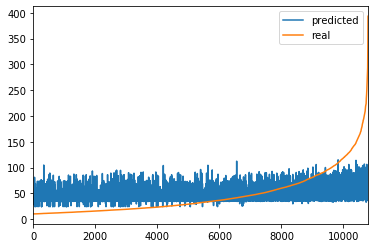

In [79]:
results.plot()

# XGBoost

In [80]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [81]:
param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'mae'}
bst = xgb.train(param, dtrain)

In [82]:
preds = bst.predict(dtest)

In [83]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 27.656414125269848
mean squared error: 1559.9266866200776
root mean squared error: 39.49590721353388
R2: 0.14146464133427883


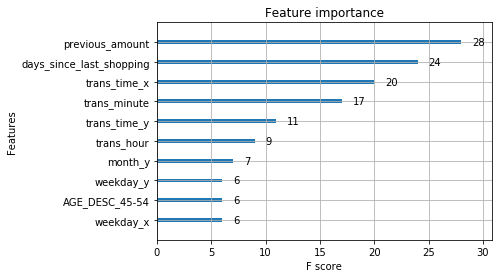

In [84]:
xgb.plot_importance(bst,max_num_features=10)

In [85]:
bst.get_score(importance_type='gain')

{'previous_amount': 94786.28168250003,
 'HOMEOWNER_DESC_Homeowner': 124911.63906,
 'days_since_last_shopping': 93397.24814875,
 'HOMEOWNER_DESC_Probable Renter': 33272.25,
 'KID_CATEGORY_DESC_2': 82681.75,
 'STORE_ID_446': 2300.92969,
 'STORE_ID_412': 48554.16405,
 'AGE_DESC_65+': 244732.0,
 'INCOME_DESC_150-174K': 110442.20636666667,
 'MARITAL_STATUS_CODE_U': 79625.1211,
 'INCOME_DESC_50-74K': 37981.731766666664,
 'INCOME_DESC_15-24K': 43730.19986666666,
 'STORE_ID_367': 39891.068999999996,
 'trans_time_x': 25253.6200125,
 'HH_COMP_DESC_Single Male': 18288.59352,
 'INCOME_DESC_35-49K': 54622.46454,
 'KID_CATEGORY_DESC_None/Unknown': 65208.94793333334,
 'STORE_ID_293': 6195.65625,
 'trans_time_y': 35862.251110000005,
 'trans_hour': 17867.503687777775,
 'HOUSEHOLD_SIZE_DESC_5+': 41582.53905,
 'INCOME_DESC_250K+': 40666.75,
 'STORE_ID_372': 56861.4336,
 'STORE_ID_296': 25145.752950000002,
 'STORE_ID_338': 29874.8076,
 'INCOME_DESC_125-149K': 78356.79295,
 'STORE_ID_443': 61751.125,
 'STO

In [86]:
results = pd.DataFrame({'predicted':preds, 'real':y_test}).sort_values(by=['real','predicted'])
results = results.reset_index().drop('index', axis=1)
results.head(100)

,predicted,real
0,7.286314,10.00
1,17.472797,10.00
2,17.972404,10.00
3,18.961395,10.00
4,25.809771,10.00
5,26.069492,10.00
6,26.831533,10.00
7,27.189524,10.00
8,27.860910,10.00
9,28.070679,10.00


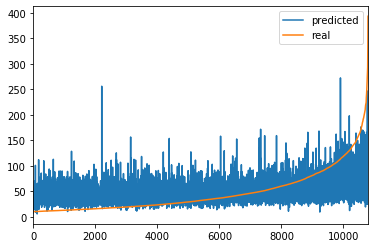

In [87]:
results.plot()

In [ ]:
results.plot(kind='scatter',figsize=(20,10), x='real', y='predicted')

In [ ]:
results.head(7000).plot(figsize=(20,10))

In [ ]:
results.tail(7000).plot(figsize=(20,10))